# Práctica Final

In [1]:
import numpy as np
import pandas as pd
import random
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from textblob import TextBlob
from scipy import stats
from sklearn.linear_model import LinearRegression

sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)

### Funciones

Sentimiento para una palabra

In [2]:
def word_sentiments(word, tweet_df):
    tweet_batch = tweet_df.loc[tweet_df.loc[:, 'text'].str.contains(fr'\b{word}')].copy()
    
    sentiments = []
    for tweet in tweet_batch['text']:
        sentiments.append(TextBlob(tweet).sentiment.polarity)
    
    tweet_batch['sentiment'] = sentiments
    
    return tweet_batch

Sentimiento para las compañias

In [3]:
def get_companies_transactions(companies, tweets_df, stocks_df, window, view_data=False):
    
    polarities, differences, related_company = [] , [], []
    for company in companies:
        
        tweets = word_sentiments(company, tweets_df)
        company_stocks = stocks_df.loc[stocks_df.loc[:,"name"].str.contains(fr'\b{company.upper()}')].copy()
        
        for _, tweet in tweets.iterrows():
            
            open_ = company_stocks.loc[company_stocks["date"]==tweet.created_at.date(), "open"]
            
            if len(open_) == 0:
                for _, row in company_stocks.iterrows():
                    if row.date.date() > tweet.created_at.date():
                        open_ = company_stocks.loc[company_stocks['date'] == row.date, 'open']
                        break
                        
            close_ = company_stocks.loc[open_.index + window,"close"]
            dif_ = (close_.values - open_.values)/open_.values*100
            
            polarities.append(tweet.sentiment)
            differences.append(dif_)
            related_company.append(company)
    
    if view_data:
        plot_stats(polarities, differences)
    
    return polarities, differences, related_company        
    

Regresion

In [20]:
def get_regression(polarities, differences, horizon):
    print(f'{horizon+1} día(s) de bolsa contabilizado(s)')
    
    pol = np.asarray(polarities)
    diff = np.asarray(differences)
    diff = diff.reshape(-1)
    
    coe_pearson = stats.pearsonr(pol, diff)
    print('Hemos obtenido un r = {} con un p-valor de: {}' .format(coe_pearson[0], coe_pearson[1]))
    
    X_pred = np.empty(shape=[10,])
    for i in range(0,10):
        a = random.uniform(-1, 1)
        X_pred[i] = a

    X_pred = X_pred.reshape(-1 , 1)

    pol = pol.reshape(-1,1)
    diff = diff.reshape(-1,1)
    
    regr = LinearRegression()

    regr.fit(pol, diff)

    predicts = regr.predict(X_pred)
    print('Coeficiente de la regresión: \n', regr.coef_)
    plot_stats(pol, diff, reg_info=[X_pred, predicts])

Analisis completo

In [5]:
def full_analysis(companies, tweets, stocks, windows):
    
    for window in range(windows):
        polarities, differences, _ = get_companies_transactions(companies, tweets, stocks, window)
        get_regression(polarities, differences, window)

Visualización

In [6]:
def plot_stats(polarities, differences, reg_info=None):
    
    plt.xlim((-1, 1))
    plt.ylim((-5, 5))
    
    plt.xlabel('Tweet polarity')
    plt.ylabel('Stock trend')
    plt.title('Trump tweets vs stocks')
    
    plt.scatter(polarities, differences, c=differences, cmap='RdYlGn')
    if reg_info is not None:
        X_pred, predicts = reg_info
        plt.scatter(X_pred, predicts,  color='b', label='predicted')
        plt.plot(X_pred, predicts, linewidth=1, linestyle='dashed', label='regression line')
        plt.legend()
    
    plt.grid(True)
    plt.show()

### Preprocesamiento

#### Tweets

In [7]:
tweets = pd.read_csv('trump_tweets.csv')

##### Object column to datetime

In [8]:
tweets.loc[:,'created_at'] = pd.to_datetime(tweets.loc[:,'created_at'])

Filtramos las fechas fuera de scope

In [9]:
tweets = tweets.loc[tweets['created_at'] >= datetime.strptime('2017-01-20', "%Y-%m-%d").date()]
tweets = tweets.loc[tweets['created_at'] <= datetime.strptime('2018-08-24', "%Y-%m-%d").date()]

##### To lowercase

In [10]:
tweets['text'] = tweets['text'].str.lower() 

#### Bolsa

In [11]:
bolsa = pd.read_csv('bolsa.csv', index_col=0)
bolsa = bolsa.reset_index(drop=True)

##### Value at open vs value at close

In [12]:
bolsa['difference'] = (bolsa['close'] - bolsa['open'])/(bolsa['open']) * 100

##### Column stating if the values went down 

In [13]:
bolsa['goes_down'] = bolsa['difference'] < 0

##### To datetime

In [14]:
bolsa.loc[:,'date'] = pd.to_datetime(bolsa.loc[:,'date'])

#### Tickers

In [15]:
tickers = pd.read_csv('historical_stocks.csv')

##### Bolsa w/ extended info

In [16]:
bolsa_ext = pd.merge(bolsa, tickers, on=['ticker'])

##### Tweets por cada empresa

In [17]:
empresas = ['amazon', 'facebook', 'general motors', 'toyota', 'alphabet', 'ibm', 'apple', 'microsoft', 'netflix', 'american airlines', 'amd', 'ebay', 'tesla', 'alibaba']

In [18]:
tweet_count = []
tweet_collection = []
for empresa in empresas:
    batch = word_sentiments(empresa, tweets)
    tweet_count.append(len(batch))
    tweet_collection.append(batch)

zipped = list(zip(empresas, tweet_count))

for pair in zipped:
    print(pair)

('amazon', 21)
('facebook', 8)
('general motors', 1)
('toyota', 3)
('alphabet', 0)
('ibm', 0)
('apple', 4)
('microsoft', 0)
('netflix', 0)
('american airlines', 1)
('amd', 0)
('ebay', 0)
('tesla', 0)
('alibaba', 0)


##### Filtering

Necesario eliminar 'APLE'; coincide con APPLE

In [19]:
bolsa_ext = bolsa_ext[~bolsa_ext['ticker'].isin(['APLE'])]

### Análisis de los datos

1 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = 0.18751979333689067 con un p-valor de: 0.2595855740971544
Coeficiente de la regresión: 
 [[0.90276864]]


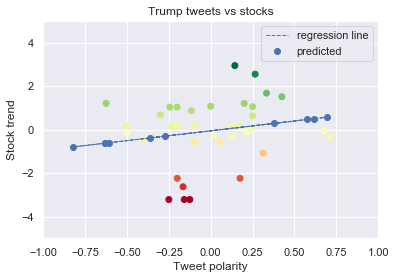

2 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = 0.06447474515350671 con un p-valor de: 0.7005539767134468
Coeficiente de la regresión: 
 [[0.35166886]]


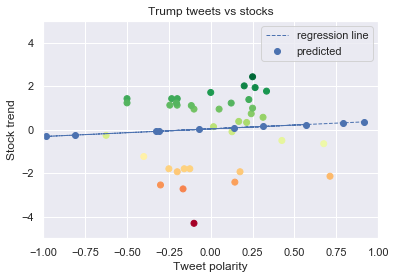

3 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = 0.07500453253544702 con un p-valor de: 0.6544814724379313
Coeficiente de la regresión: 
 [[0.5125846]]


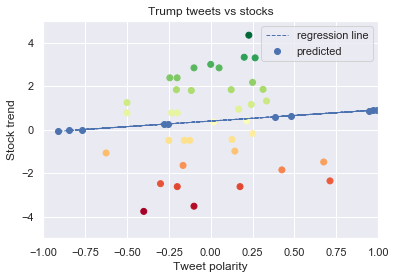

4 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = 0.044971790540869166 con un p-valor de: 0.7886226517112448
Coeficiente de la regresión: 
 [[0.33325217]]


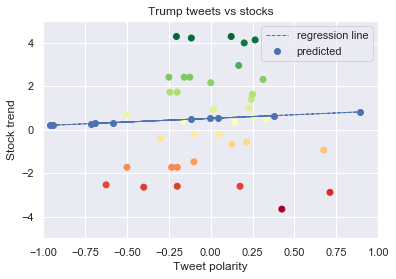

In [21]:
full_analysis(empresas, tweets, bolsa_ext, windows=4)